In [29]:
from rdkit import Chem, RDLogger, DataStructs 
from rdkit.Chem import Descriptors, AllChem, MACCSkeys, Draw
from rdkit.Chem.rdmolfiles import SmilesMolSupplier, ForwardSDMolSupplier
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import Image
import numpy as np
import pandas as pd
import seaborn as sns

In [30]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

Напишем функции, необходимые для нахождения коэффициента Танимото для каждой пары молекул, выделения пар с коэффициентом, превышающим установленный порог и визуализации выбранных молекул.

In [31]:
def get_dataframe_similarity_moleculs(file_smile_txt, type_fingerprints):
    """
    find Tanimoto similarity of molecules
    
    Parametrs
    ---------
    file_smile_txt: file with molecules
    type_fingerprints: type of molecular fingerprints
    
    Return
    ------
    dataframe with Tanimoto similarity for each pair of molecules
    """
    mol_list = Chem.SmilesMolSupplier(file_smile_txt, delimiter = '\t', titleLine = False)
    list_smiles = []
    for i in mol_list:
        list_smiles.append(Chem.MolToSmiles(i)) 
    if type_fingerprints== 'RDKFingerprint':
        fps = [Chem.RDKFingerprint(x) for x in mol_list]
    elif type_fingerprints == "MACCSkeys":
        fps = [MACCSkeys.GenMACCSKeys(x) for x in mol_list]
    elif type_fingerprints == "MorganFingerprint":
        fps = [AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits = 1024) for x in mol_list]
    Similarity_fps = np.zeros((len(fps), len(fps)))
    for i in range(len(fps)):
        for j in range(len(fps)):
            Similarity_fps[i,j] = DataStructs.FingerprintSimilarity(fps[i], fps[j])
    molecules = pd.DataFrame(Similarity_fps, columns = list_smiles)
    molecules.index =list_smiles
    molecules.head()
    return molecules

def get_pairs_similarity_moleculs(molecules, treshold):
    """
    find the pairs of molecules with Tanimoto coefficient higher than the threshold
    
    Parametrs
    ---------
    molecules: dataframe with Tanimoto similarity for each pair of molecules
    treshold: set threshold
    
    Return
    ------
    list of the pairs of molecules with Tanimoto coefficient higher than the threshold
    """
    pairs = []
    for i in molecules.columns:
        for j in molecules.index:
            if (molecules[i][j] >= treshold) & (i != j) & (not ((j, i) in pairs)):#отбираем коэффициенты выше порога и убираем коэффициенты для повторяющихся пар и пар, содержащих одинаковые молекулы
                pairs.append((i, j))
    print(len(pairs))
    print(pairs)
    return pairs

def draw_molecules(pairs, name_img):
    """
    draw molecules and saves the image
    
    Parametrs
    ---------
    pairs: list of the pairs of molecules
    name_img: name under which the image will be saved
    """
    list_mol = [x for pair in pairs for x in pair]
    mols = [Chem.MolFromSmiles(x) for x in list_mol]
    img = Draw.MolsToGridImage(mols, molsPerRow = 2, subImgSize = (200, 200))
    img.save(name_img)
    Draw.MolsToGridImage(mols, molsPerRow = 2, subImgSize = (400, 400))
    

Для  коэффициента Танимото установим порог, равный 0.75. Будем работать отдельно с каждым типом "molecular fingerprints".

# Topological Fingerprints

In [32]:
molecules = get_dataframe_similarity_moleculs( "SMILES_tutorial.txt", "RDKFingerprint" )
molecules.head()

,CC1=C(C(=O)Nc2cc3cn[nH]c3cc2F)C(c2ccc(C(F)(F)F)cc2)CC(=O)N1,CN(CCOc1ccc(CC(Nc2ccccc2C(=O)c2ccccc2)C(=O)O)cc1)c1ccccn1,CC(N)Cc1c[nH]c2ccc(OCc3cccs3)cc12,C[C@]12C[C@H](O)C3C(CCC4=CC(=O)C=C[C@@]43C)C1CC[C@]2(O)C(=O)CO,COc1cc2c(cc1OC)C(=O)C(CC1CCN(Cc3ccccc3)CC1)C2,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)(C(=O)CO)C[C@@H]3OC1C[C@H](N)[C@H](O)[C@H](C)O1,CC(c1cc2ccccc2s1)N(O)C(N)=O,CNC(=Nc1ccc(C2=NNC(=O)CC2C)cc1)NC#N,COC1CC2CCC(C)C(O)(O2)C(=O)C(=O)N2CCCCC2C(=O)OC(C(C)CC2CCC(O)C(OC)C2)CC(=O)C(C)C=C(C)C(O)C(OC)C(=O)C(C)CC(C)C=CC=CC=C1C,CC(=O)OCC(=O)[C@@]1(O)[C@@H](C)CC2C3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@@]21C,...,NCCNS(=O)(=O)c1cccc2cnccc12,CCOC(=O)c1sc(SCc2ccccc2)c2c1CC(C)(C)CC2=O,Oc1nc(SCc2ccc(Cl)cc2)nc2c1CCC2,O=C(OCC#CCSc1nnc(-c2ccccc2F)o1)c1ccc(F)cc1,C[C@H]1CCCCO[C@H](CN(C)C(=O)Nc2ccccc2)[C@H](C)CN([C@H](C)CO)C(=O)c2cc(NC(=O)C3CCCCC3)ccc2O1,C[C@@H]1CN([C@H](C)CO)C(=O)Cc2cc(NC(=O)CCCCCC(=O)Nc3ccccc3N)ccc2O[C@@H]1CN(C)Cc1ccc(-c2ccccc2)cc1,CCOc1ccccc1CNc1ncnc2ccc(-c3c(C)noc3C)cc12,Cc1ccc2oc(-c3cccc(NC(=O)c4cc(-n5cnnc5)ccc4Cl)c3)nc2c1,C[C@H](N)C(=O)N[C@@H](C)C(=O)N[C@@H](Cc1ccccc1)C(=O)CCl,O=C(OCC#CCSc1nnc(-c2cccc(F)c2)o1)c1ccc(F)cc1
CC1=C(C(=O)Nc2cc3cn[nH]c3cc2F)C(c2ccc(C(F)(F)F)cc2)CC(=O)N1,1.000000,0.354465,0.310617,0.273913,0.322581,0.495756,0.269727,0.294556,0.411295,0.351007,...,0.207988,0.433939,0.288395,0.300069,0.430269,0.423598,0.368522,0.398859,0.260337,0.288529
CN(CCOc1ccc(CC(Nc2ccccc2C(=O)c2ccccc2)C(=O)O)cc1)c1ccccn1,0.354465,1.000000,0.314783,0.192562,0.346187,0.382423,0.225779,0.269884,0.311302,0.246696,...,0.176256,0.347569,0.250203,0.254823,0.350685,0.365801,0.327511,0.322378,0.254477,0.247737
CC(N)Cc1c[nH]c2ccc(OCc3cccs3)cc12,0.310617,0.314783,1.000000,0.180313,0.289762,0.319537,0.260954,0.225462,0.262284,0.227454,...,0.218143,0.309557,0.268629,0.238727,0.287846,0.303008,0.310236,0.288905,0.235232,0.241758
C[C@]12C[C@H](O)C3C(CCC4=CC(=O)C=C[C@@]43C)C1CC[C@]2(O)C(=O)CO,0.273913,0.192562,0.180313,1.000000,0.213382,0.303727,0.170965,0.194389,0.346892,0.704176,...,0.138710,0.261773,0.200733,0.187166,0.258484,0.243647,0.222222,0.252449,0.162447,0.183993
COc1cc2c(cc1OC)C(=O)C(CC1CCN(Cc3ccccc3)CC1)C2,0.322581,0.346187,0.289762,0.213382,1.000000,0.383230,0.243343,0.263158,0.309458,0.264450,...,0.177579,0.356994,0.266960,0.247863,0.374724,0.377402,0.311263,0.288697,0.264132,0.240140


In [33]:
pairs_RDK=get_pairs_similarity_moleculs(molecules, 0.75)

7
[('CC(=O)OCC(=O)[C@@]1(O)[C@@H](C)CC2C3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@@]21C', 'CC(=O)OCC(=O)[C@@]1(O)[C@H](C)C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@@]21C'), ('C[C@@H](CO)N1C[C@@H](C)[C@H](CN(C)Cc2ccc(C(F)(F)F)cc2)Oc2ccc(NC(=O)Nc3ccccc3)cc2C1=O', 'C[C@H]1CN([C@H](C)CO)C(=O)c2cc(N(C)C)ccc2O[C@H]1CN(C)Cc1ccc(C(=O)Nc2ccccc2N)cc1'), ('COc1ccc(S(=O)(=O)N(C)C[C@H]2Oc3c(NC(=O)Nc4ccccc4)cccc3C(=O)N([C@H](C)CO)C[C@H]2C)cc1', 'COc1ccc(S(=O)(=O)N(C)C[C@@H]2Oc3c(NC(=O)Nc4cccc5ccccc45)cccc3C(=O)N([C@H](C)CO)C[C@H]2C)cc1'), ('CC(=O)Nc1sc2c(c1-c1nc3ccccc3s1)CCCNC2', 'CC(=O)Nc1sc2c(c1-c1nc3ccccc3s1)CCN(C)C2'), ('C[C@H]1CN([C@H](C)CO)C(=O)Cc2cc(NC(=O)Nc3cccc4ccccc34)ccc2O[C@@H]1CN(C)Cc1ccc(-c2ccccc2)cc1', 'C[C@@H]1CN([C@H](C)CO)C(=O)Cc2cc(NC(=O)CCCCCC(=O)Nc3ccccc3N)ccc2O[C@@H]1CN(C)Cc1ccc(-c2ccccc2)cc1'), ('Cc1noc(C)c1NC(=O)Nc1ccc2c(c1)C(=O)N([C@H](C)CO)C[C@H](C)[C@@H](CN(C)C(=O)C1CCCCC1)OCCCC[C@H](C)O2', 'C[C@H]1CCCCO[C@H](CN(C)C(=O)Nc2ccccc2)[C@H](C)CN([C@H](C)CO)C(=O

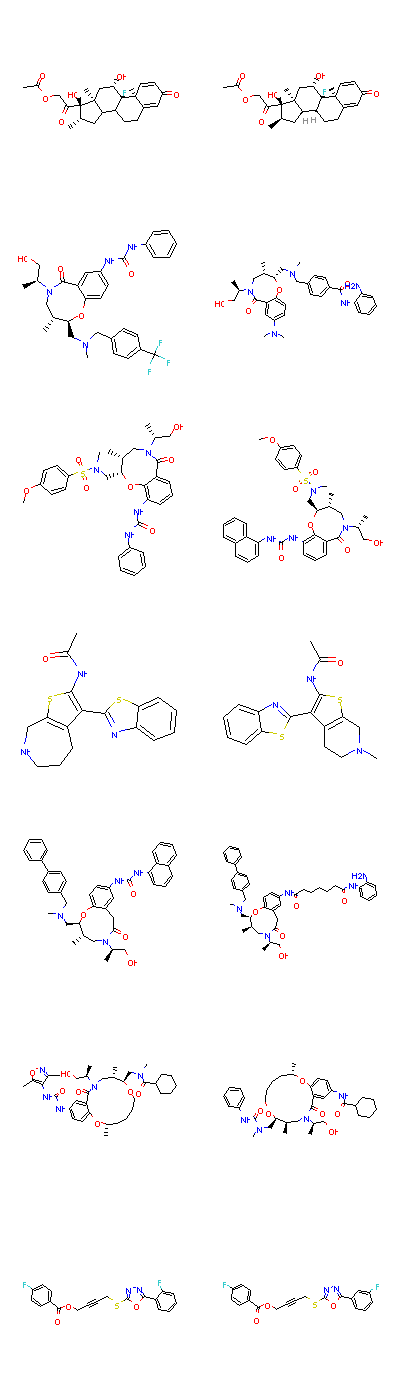

In [34]:
draw_molecules(pairs_RDK, "mols_RDK_0.75.png")
Image(filename = "mols_RDK_0.75.png")

# MACCS Keys

In [35]:
molecules = get_dataframe_similarity_moleculs("SMILES_tutorial.txt", "MACCSkeys")
molecules.head()

,CC1=C(C(=O)Nc2cc3cn[nH]c3cc2F)C(c2ccc(C(F)(F)F)cc2)CC(=O)N1,CN(CCOc1ccc(CC(Nc2ccccc2C(=O)c2ccccc2)C(=O)O)cc1)c1ccccn1,CC(N)Cc1c[nH]c2ccc(OCc3cccs3)cc12,C[C@]12C[C@H](O)C3C(CCC4=CC(=O)C=C[C@@]43C)C1CC[C@]2(O)C(=O)CO,COc1cc2c(cc1OC)C(=O)C(CC1CCN(Cc3ccccc3)CC1)C2,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)(C(=O)CO)C[C@@H]3OC1C[C@H](N)[C@H](O)[C@H](C)O1,CC(c1cc2ccccc2s1)N(O)C(N)=O,CNC(=Nc1ccc(C2=NNC(=O)CC2C)cc1)NC#N,COC1CC2CCC(C)C(O)(O2)C(=O)C(=O)N2CCCCC2C(=O)OC(C(C)CC2CCC(O)C(OC)C2)CC(=O)C(C)C=C(C)C(O)C(OC)C(=O)C(C)CC(C)C=CC=CC=C1C,CC(=O)OCC(=O)[C@@]1(O)[C@@H](C)CC2C3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@@]21C,...,NCCNS(=O)(=O)c1cccc2cnccc12,CCOC(=O)c1sc(SCc2ccccc2)c2c1CC(C)(C)CC2=O,Oc1nc(SCc2ccc(Cl)cc2)nc2c1CCC2,O=C(OCC#CCSc1nnc(-c2ccccc2F)o1)c1ccc(F)cc1,C[C@H]1CCCCO[C@H](CN(C)C(=O)Nc2ccccc2)[C@H](C)CN([C@H](C)CO)C(=O)c2cc(NC(=O)C3CCCCC3)ccc2O1,C[C@@H]1CN([C@H](C)CO)C(=O)Cc2cc(NC(=O)CCCCCC(=O)Nc3ccccc3N)ccc2O[C@@H]1CN(C)Cc1ccc(-c2ccccc2)cc1,CCOc1ccccc1CNc1ncnc2ccc(-c3c(C)noc3C)cc12,Cc1ccc2oc(-c3cccc(NC(=O)c4cc(-n5cnnc5)ccc4Cl)c3)nc2c1,C[C@H](N)C(=O)N[C@@H](C)C(=O)N[C@@H](Cc1ccccc1)C(=O)CCl,O=C(OCC#CCSc1nnc(-c2cccc(F)c2)o1)c1ccc(F)cc1
CC1=C(C(=O)Nc2cc3cn[nH]c3cc2F)C(c2ccc(C(F)(F)F)cc2)CC(=O)N1,1.000000,0.357143,0.357143,0.307692,0.282051,0.395062,0.342466,0.537313,0.392857,0.337500,...,0.337349,0.256410,0.424658,0.432432,0.404494,0.415730,0.434211,0.552239,0.304348,0.405405
CN(CCOc1ccc(CC(Nc2ccccc2C(=O)c2ccccc2)C(=O)O)cc1)c1ccccn1,0.357143,1.000000,0.417910,0.360000,0.538462,0.569444,0.272727,0.373333,0.560000,0.371795,...,0.337349,0.342466,0.350649,0.308642,0.666667,0.680000,0.472973,0.350649,0.363636,0.283951
CC(N)Cc1c[nH]c2ccc(OCc3cccs3)cc12,0.357143,0.417910,1.000000,0.296875,0.372881,0.424242,0.362069,0.312500,0.324324,0.294118,...,0.333333,0.410714,0.440678,0.318182,0.376623,0.407895,0.451613,0.307692,0.339623,0.328125
C[C@]12C[C@H](O)C3C(CCC4=CC(=O)C=C[C@@]43C)C1CC[C@]2(O)C(=O)CO,0.307692,0.360000,0.296875,1.000000,0.375000,0.553846,0.162162,0.197368,0.567164,0.826923,...,0.192771,0.409836,0.243243,0.175000,0.448718,0.443038,0.259740,0.150000,0.278689,0.164557
COc1cc2c(cc1OC)C(=O)C(CC1CCN(Cc3ccccc3)CC1)C2,0.282051,0.538462,0.372881,0.375000,1.000000,0.477612,0.253731,0.253521,0.492754,0.367647,...,0.293333,0.423729,0.363636,0.295775,0.541667,0.534247,0.461538,0.343284,0.266667,0.267606


In [36]:
pairs_MACCSkeys = get_pairs_similarity_moleculs(molecules, 0.75)

29
[('C[C@]12C[C@H](O)C3C(CCC4=CC(=O)C=C[C@@]43C)C1CC[C@]2(O)C(=O)CO', 'CC(=O)OCC(=O)[C@@]1(O)[C@@H](C)CC2C3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@@]21C'), ('C[C@]12C[C@H](O)C3C(CCC4=CC(=O)C=C[C@@]43C)C1CC[C@]2(O)C(=O)CO', 'CC(=O)OCC(=O)[C@@]1(O)[C@H](C)C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@@]21C'), ('COC1CC2CCC(C)C(O)(O2)C(=O)C(=O)N2CCCCC2C(=O)OC(C(C)CC2CCC(O)C(OC)C2)CC(=O)C(C)C=C(C)C(O)C(OC)C(=O)C(C)CC(C)C=CC=CC=C1C', 'C=C1[C@@H](C)[C@H]2[C@H](Cc3ccccc3)NC(=O)[C@]23OC(=O)C=C[C@H](O)CCC[C@@H](C)CC=C[C@H]3[C@@H]1O'), ('CC(=O)OCC(=O)[C@@]1(O)[C@@H](C)CC2C3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@@]21C', 'CC(=O)OCC(=O)[C@@]1(O)[C@H](C)C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@@]21C'), ('CC(=O)OCC(=O)[C@@]1(O)[C@@H](C)CC2C3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@@]21C', 'CC1(C)O[C@@H]2C[C@H]3[C@@H]4C[C@H](F)C5=CC(=O)C=C[C@]5(C)[C@H]4[C@@H](O)C[C@]3(C)[C@]2(C(=O)CO)O1'), ('C=CC(=O)Nc1cccc(Oc2nc(Nc3ccc(N4CCN(C)CC4)cc3)ncc2Cl)c1', 'O=c1cc(N2CCN

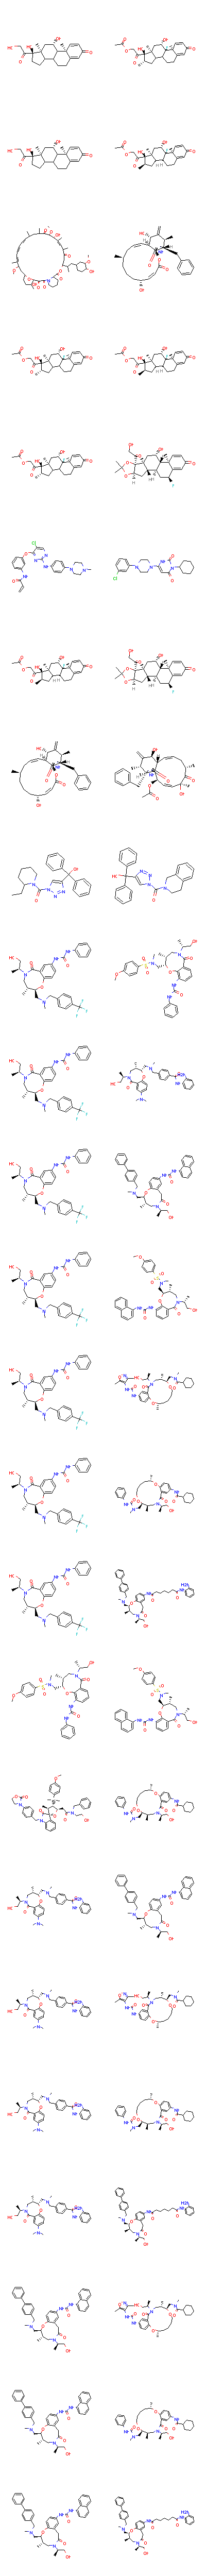

In [37]:
draw_molecules(pairs_MACCSkeys, "mols_MACCSkeys_0.75.png")
Image(filename = "mols_MACCSkeys_0.75.png")

# Morgan Fingerprints

In [38]:
molecules = get_dataframe_similarity_moleculs("SMILES_tutorial.txt", "MorganFingerprint")
molecules.head()

,CC1=C(C(=O)Nc2cc3cn[nH]c3cc2F)C(c2ccc(C(F)(F)F)cc2)CC(=O)N1,CN(CCOc1ccc(CC(Nc2ccccc2C(=O)c2ccccc2)C(=O)O)cc1)c1ccccn1,CC(N)Cc1c[nH]c2ccc(OCc3cccs3)cc12,C[C@]12C[C@H](O)C3C(CCC4=CC(=O)C=C[C@@]43C)C1CC[C@]2(O)C(=O)CO,COc1cc2c(cc1OC)C(=O)C(CC1CCN(Cc3ccccc3)CC1)C2,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)(C(=O)CO)C[C@@H]3OC1C[C@H](N)[C@H](O)[C@H](C)O1,CC(c1cc2ccccc2s1)N(O)C(N)=O,CNC(=Nc1ccc(C2=NNC(=O)CC2C)cc1)NC#N,COC1CC2CCC(C)C(O)(O2)C(=O)C(=O)N2CCCCC2C(=O)OC(C(C)CC2CCC(O)C(OC)C2)CC(=O)C(C)C=C(C)C(O)C(OC)C(=O)C(C)CC(C)C=CC=CC=C1C,CC(=O)OCC(=O)[C@@]1(O)[C@@H](C)CC2C3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@@]21C,...,NCCNS(=O)(=O)c1cccc2cnccc12,CCOC(=O)c1sc(SCc2ccccc2)c2c1CC(C)(C)CC2=O,Oc1nc(SCc2ccc(Cl)cc2)nc2c1CCC2,O=C(OCC#CCSc1nnc(-c2ccccc2F)o1)c1ccc(F)cc1,C[C@H]1CCCCO[C@H](CN(C)C(=O)Nc2ccccc2)[C@H](C)CN([C@H](C)CO)C(=O)c2cc(NC(=O)C3CCCCC3)ccc2O1,C[C@@H]1CN([C@H](C)CO)C(=O)Cc2cc(NC(=O)CCCCCC(=O)Nc3ccccc3N)ccc2O[C@@H]1CN(C)Cc1ccc(-c2ccccc2)cc1,CCOc1ccccc1CNc1ncnc2ccc(-c3c(C)noc3C)cc12,Cc1ccc2oc(-c3cccc(NC(=O)c4cc(-n5cnnc5)ccc4Cl)c3)nc2c1,C[C@H](N)C(=O)N[C@@H](C)C(=O)N[C@@H](Cc1ccccc1)C(=O)CCl,O=C(OCC#CCSc1nnc(-c2cccc(F)c2)o1)c1ccc(F)cc1
CC1=C(C(=O)Nc2cc3cn[nH]c3cc2F)C(c2ccc(C(F)(F)F)cc2)CC(=O)N1,1.000000,0.116505,0.095745,0.103093,0.105263,0.094828,0.108434,0.159091,0.091549,0.114286,...,0.105882,0.130435,0.117647,0.148936,0.107438,0.142857,0.099010,0.150000,0.103448,0.147368
CN(CCOc1ccc(CC(Nc2ccccc2C(=O)c2ccccc2)C(=O)O)cc1)c1ccccn1,0.116505,1.000000,0.133333,0.081633,0.118280,0.125000,0.151899,0.122222,0.054795,0.104762,...,0.120482,0.170455,0.105882,0.150538,0.136752,0.173913,0.122449,0.140000,0.233766,0.161290
CC(N)Cc1c[nH]c2ccc(OCc3cccs3)cc12,0.095745,0.133333,1.000000,0.056180,0.150000,0.096154,0.144928,0.072289,0.092308,0.061224,...,0.094595,0.123457,0.051282,0.104651,0.090090,0.108108,0.180723,0.085106,0.152778,0.116279
C[C@]12C[C@H](O)C3C(CCC4=CC(=O)C=C[C@@]43C)C1CC[C@]2(O)C(=O)CO,0.103093,0.081633,0.056180,1.000000,0.103448,0.180000,0.092105,0.107143,0.106061,0.350000,...,0.049383,0.130952,0.075000,0.076087,0.136364,0.123894,0.073684,0.104167,0.101266,0.075269
COc1cc2c(cc1OC)C(=O)C(CC1CCN(Cc3ccccc3)CC1)C2,0.105263,0.118280,0.150000,0.103448,1.000000,0.171717,0.109589,0.109756,0.125000,0.115789,...,0.092105,0.177215,0.105263,0.102273,0.160377,0.157407,0.149425,0.106383,0.164384,0.088889


In [39]:
pairs_MorganFingerprin = get_pairs_similarity_moleculs(molecules, 0.75)

2
[('CC(=O)OCC(=O)[C@@]1(O)[C@@H](C)CC2C3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@@]21C', 'CC(=O)OCC(=O)[C@@]1(O)[C@H](C)C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@@]21C'), ('COc1ccc(S(=O)(=O)N(C)C[C@H]2Oc3c(NC(=O)Nc4ccccc4)cccc3C(=O)N([C@H](C)CO)C[C@H]2C)cc1', 'COc1ccc(S(=O)(=O)N(C)C[C@@H]2Oc3c(NC(=O)Nc4cccc5ccccc45)cccc3C(=O)N([C@H](C)CO)C[C@H]2C)cc1')]


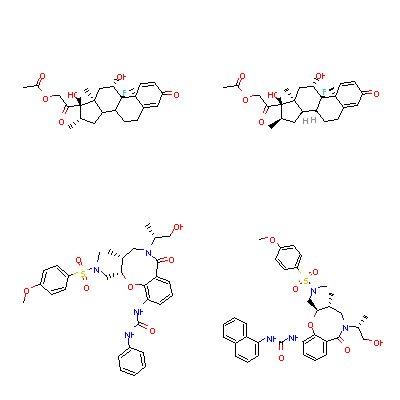

In [40]:
draw_molecules(pairs_MorganFingerprin, "mols_MorganFingerprint_0.75.png")
Image(filename = "mols_MorganFingerprint_0.75.png")

# Найдем общие молекулы.

Посмотрим пересечение списков пар молекул с коэффициентом Танимото больше 0,75 для каждых 2 типов "molecular fingerprints".

In [41]:
pairs = set(pairs_MorganFingerprin) & set(pairs_MACCSkeys)
print(len(pairs))
print(pairs)

2
{('COc1ccc(S(=O)(=O)N(C)C[C@H]2Oc3c(NC(=O)Nc4ccccc4)cccc3C(=O)N([C@H](C)CO)C[C@H]2C)cc1', 'COc1ccc(S(=O)(=O)N(C)C[C@@H]2Oc3c(NC(=O)Nc4cccc5ccccc45)cccc3C(=O)N([C@H](C)CO)C[C@H]2C)cc1'), ('CC(=O)OCC(=O)[C@@]1(O)[C@@H](C)CC2C3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@@]21C', 'CC(=O)OCC(=O)[C@@]1(O)[C@H](C)C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@@]21C')}


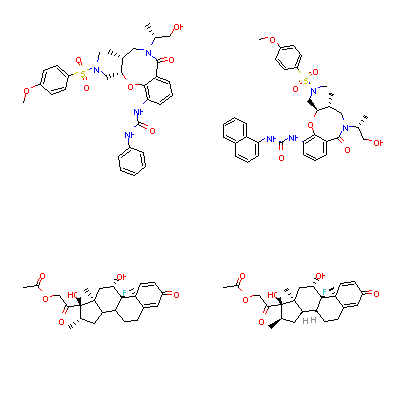

In [42]:
draw_molecules(pairs, "mols_MorganFingerprin&MACCSkeys_0.75.png")
Image(filename = "mols_MorganFingerprin&MACCSkeys_0.75.png")

In [43]:
pairs = set(pairs_MACCSkeys) & set(pairs_RDK)
print(len(pairs))
print(pairs)

6
{('C[C@H]1CN([C@H](C)CO)C(=O)Cc2cc(NC(=O)Nc3cccc4ccccc34)ccc2O[C@@H]1CN(C)Cc1ccc(-c2ccccc2)cc1', 'C[C@@H]1CN([C@H](C)CO)C(=O)Cc2cc(NC(=O)CCCCCC(=O)Nc3ccccc3N)ccc2O[C@@H]1CN(C)Cc1ccc(-c2ccccc2)cc1'), ('O=C(OCC#CCSc1nnc(-c2ccccc2F)o1)c1ccc(F)cc1', 'O=C(OCC#CCSc1nnc(-c2cccc(F)c2)o1)c1ccc(F)cc1'), ('C[C@@H](CO)N1C[C@@H](C)[C@H](CN(C)Cc2ccc(C(F)(F)F)cc2)Oc2ccc(NC(=O)Nc3ccccc3)cc2C1=O', 'C[C@H]1CN([C@H](C)CO)C(=O)c2cc(N(C)C)ccc2O[C@H]1CN(C)Cc1ccc(C(=O)Nc2ccccc2N)cc1'), ('CC(=O)OCC(=O)[C@@]1(O)[C@@H](C)CC2C3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@@]21C', 'CC(=O)OCC(=O)[C@@]1(O)[C@H](C)C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@@]21C'), ('COc1ccc(S(=O)(=O)N(C)C[C@H]2Oc3c(NC(=O)Nc4ccccc4)cccc3C(=O)N([C@H](C)CO)C[C@H]2C)cc1', 'COc1ccc(S(=O)(=O)N(C)C[C@@H]2Oc3c(NC(=O)Nc4cccc5ccccc45)cccc3C(=O)N([C@H](C)CO)C[C@H]2C)cc1'), ('Cc1noc(C)c1NC(=O)Nc1ccc2c(c1)C(=O)N([C@H](C)CO)C[C@H](C)[C@@H](CN(C)C(=O)C1CCCCC1)OCCCC[C@H](C)O2', 'C[C@H]1CCCCO[C@H](CN(C)C(=O)Nc2ccccc2)[C@H](C)CN([C@H]

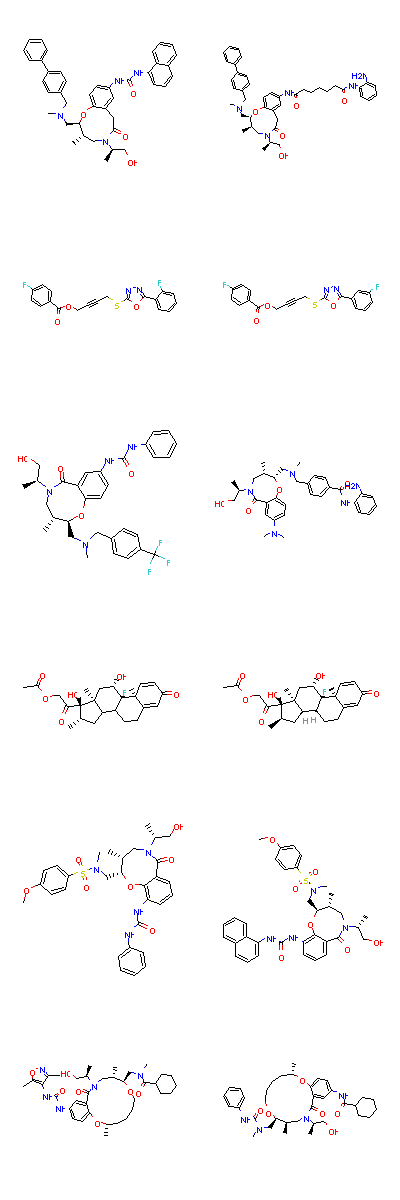

In [44]:
draw_molecules(pairs, "mols_MorganFingerprin&RDK_0.75.png")
Image(filename = "mols_MorganFingerprin&RDK_0.75.png")

In [45]:
pairs = set(pairs_MorganFingerprin) & set(pairs_RDK)
print(len(pairs))
print(pairs)

2
{('COc1ccc(S(=O)(=O)N(C)C[C@H]2Oc3c(NC(=O)Nc4ccccc4)cccc3C(=O)N([C@H](C)CO)C[C@H]2C)cc1', 'COc1ccc(S(=O)(=O)N(C)C[C@@H]2Oc3c(NC(=O)Nc4cccc5ccccc45)cccc3C(=O)N([C@H](C)CO)C[C@H]2C)cc1'), ('CC(=O)OCC(=O)[C@@]1(O)[C@@H](C)CC2C3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@@]21C', 'CC(=O)OCC(=O)[C@@]1(O)[C@H](C)C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@@]21C')}


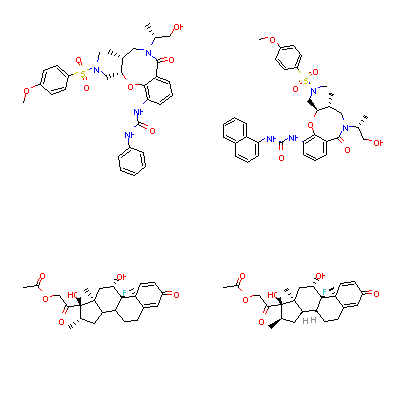

In [46]:
draw_molecules(pairs, "mols_MorganFingerprin&RDK_0.75.png")
Image(filename = "mols_MorganFingerprin&RDK_0.75.png")

Посмотрим пересечение списков пар молекул с коэффициентом Танимото больше 0,75 для всех 3 типов "molecular fingerprints".

In [47]:
cross = set(pairs_MorganFingerprin) & set(pairs_MACCSkeys) & set(pairs_RDK)
print(len(cross))
print(cross)

2
{('COc1ccc(S(=O)(=O)N(C)C[C@H]2Oc3c(NC(=O)Nc4ccccc4)cccc3C(=O)N([C@H](C)CO)C[C@H]2C)cc1', 'COc1ccc(S(=O)(=O)N(C)C[C@@H]2Oc3c(NC(=O)Nc4cccc5ccccc45)cccc3C(=O)N([C@H](C)CO)C[C@H]2C)cc1'), ('CC(=O)OCC(=O)[C@@]1(O)[C@@H](C)CC2C3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@@]21C', 'CC(=O)OCC(=O)[C@@]1(O)[C@H](C)C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@@]21C')}


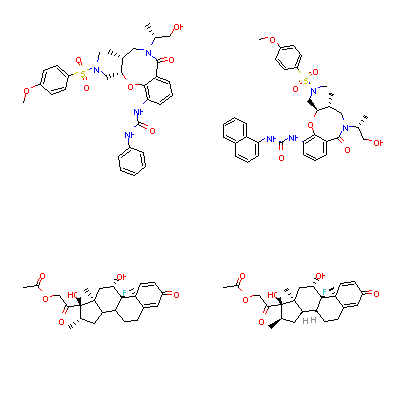

In [48]:
draw_molecules(pairs, "mols_MorganFingerprin&MACCSkeys&RDK_0.75.png")
Image(filename = "mols_MorganFingerprin&MACCSkeys&RDK_0.75.png")

Для коэффициента Танимото установим порог, равный 1.

# Morgan Fingerprints.

1
[('CC(=O)OCC(=O)[C@@]1(O)[C@@H](C)CC2C3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@@]21C', 'CC(=O)OCC(=O)[C@@]1(O)[C@H](C)C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@@]21C')]


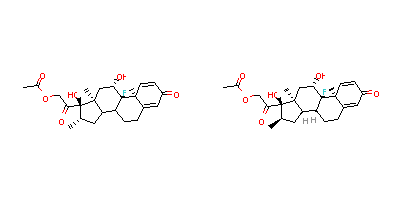

In [49]:
molecules = get_dataframe_similarity_moleculs("SMILES_tutorial.txt", "RDKFingerprint")
pairs_RDK = get_pairs_similarity_moleculs(molecules, 1)
draw_molecules(pairs_RDK, "mols_RDK_1.png")
Image(filename = "mols_RDK_1.png")

# MACCS Keys

2
[('CC(=O)OCC(=O)[C@@]1(O)[C@@H](C)CC2C3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@@]21C', 'CC(=O)OCC(=O)[C@@]1(O)[C@H](C)C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@@]21C'), ('COc1ccc(S(=O)(=O)N(C)C[C@H]2Oc3c(NC(=O)Nc4ccccc4)cccc3C(=O)N([C@H](C)CO)C[C@H]2C)cc1', 'COc1ccc(S(=O)(=O)N(C)C[C@@H]2Oc3c(NC(=O)Nc4cccc5ccccc45)cccc3C(=O)N([C@H](C)CO)C[C@H]2C)cc1')]


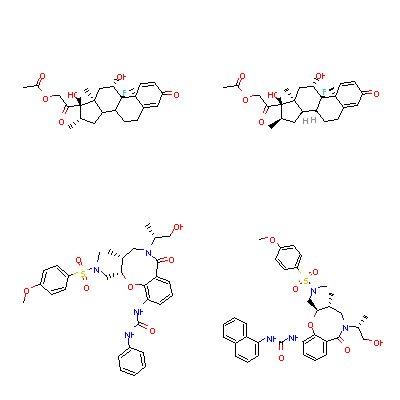

In [50]:
molecules = get_dataframe_similarity_moleculs("SMILES_tutorial.txt", "MACCSkeys")
pairs_RDK = get_pairs_similarity_moleculs(molecules, 1)
draw_molecules(pairs_RDK, "mols_RDK_1.png")
Image(filename = "mols_RDK_1.png")

# Morgan Fingerprints

1
[('CC(=O)OCC(=O)[C@@]1(O)[C@@H](C)CC2C3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@@]21C', 'CC(=O)OCC(=O)[C@@]1(O)[C@H](C)C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@@]21C')]


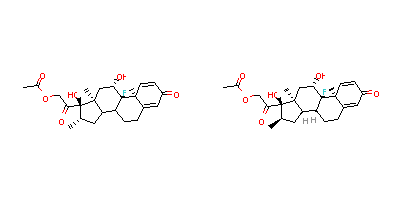

In [51]:
molecules = get_dataframe_similarity_moleculs("SMILES_tutorial.txt", "MorganFingerprint")
pairs_RDK = get_pairs_similarity_moleculs(molecules, 1)
draw_molecules(pairs_RDK, "mols_RDK_1.png")
Image(filename = "mols_RDK_1.png")

# Посмотрим корреляцию между коэффициентами Танимото для разных fingerprints.

Создали датафрейм, в котором каждый столбец представляет набор коэффициентов Танимото для конкретного fingerprints.

In [52]:
d = {}
for type in ["RDKFingerprint", "MACCSkeys", "MorganFingerprint"]:
    molecules = get_dataframe_similarity_moleculs("SMILES_tutorial.txt", type)
    pairs = []
    simmil = []
    for i in molecules.columns:
        for j in molecules.index:
            if (i != j) & (not ((j,i) in pairs)): #убираем коэффициенты для повторяющихся пар и пар, содержащих одинаковые молекулы
                pairs.append((i,j))
                simmil.append((molecules[i][j]))
    d[type] = simmil
data = pd.DataFrame(d)
data.head()

,RDKFingerprint,MACCSkeys,MorganFingerprint
0,0.354465,0.357143,0.116505
1,0.310617,0.357143,0.095745
2,0.273913,0.307692,0.103093
3,0.322581,0.282051,0.105263
4,0.495756,0.395062,0.094828


Посчитали коэффициент корреляции Спирмена для каждой пары fingerprints.

In [53]:
data.corr(method='spearman')

,RDKFingerprint,MACCSkeys,MorganFingerprint
RDKFingerprint,1.000000,0.592545,0.271102
MACCSkeys,0.592545,1.000000,0.490735
MorganFingerprint,0.271102,0.490735,1.000000


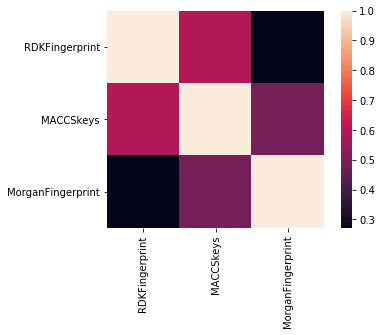

In [54]:
sns.heatmap(data.corr(method = 'spearman'), square = True)

Наибольшая корреляция наблюдается для MACCSkeys и RDKFingerprint, затем для  MACCSkeys и MorganFingerprint.